# Thiết lập

In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Lending Club Loan Data').getOrCreate()
spark

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import OneHotEncoder, StringIndexer
import warnings
warnings.filterwarnings('ignore')

# Đọc dữ liệu

In [4]:
acc = spark.read.csv('accepted_2007_to_2018Q4.csv', header=True, inferSchema=True)

In [ ]:
print(f"Accepted: ({acc.count()}, {len(acc.columns)})")

Accepted: (2260701, 151)


In [ ]:
acc.show(5)

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+---

In [ ]:
acc.describe().show()

+-------+--------------------+---------+------------------+------------------+------------------+----------+------------------+------------------+-------+---------+------------------+----------+--------------+------------------+-------------------+---------------+-----------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+----------------------+----------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------------+-----------------+------------------+-----------------+------------------+--------------------+-----------------

In [ ]:
acc.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

# Tiền xử lý




---
**Các hàm sử dụng**

In [5]:
from pyspark.sql.functions import col, corr
# Hàm tính hệ số tương quan so với giá trị mục tiêu
def target_corrs(df):
    # List to store correlations
    corrs = []

    # Iterate through the columns, skip the 'TARGET' column
    for col_name in df.columns:
        if col_name != 'loan_status':
            try:
                # Calculate correlation between 'TARGET' and current column
                corr_value = df.select(corr(col_name, 'loan_status')).collect()[0][0]

                # Append the column name and correlation value to the list
                corrs.append((col_name, corr_value))
            except Exception as e:
                print(f"Error calculating correlation for {col_name}: {e}")

    # Sort by correlation value in ascending order (from smallest to largest)
    corrs_sorted = sorted(corrs, key=lambda x: x[1] if x[1] is not None else 0)

    # Print the sorted correlations
    for col_name, corr_value in corrs_sorted:
        print(f"Column: {col_name}, Correlation with loan_status: {corr_value}")

    return corrs_sorted


In [6]:
# Hàm kiểm tra số lượng khuyết thiếu
def miss_vals(df):
    total = df.count()
    miss_vals = df.select(
        [expr(f"'{c}' as column_name") for c in df.columns] +
        [sum(col(c).isNull().cast("int")).alias(f"{c}_count") for c in df.columns] +
        [round((sum(col(c).isNull().cast("int")) / total) * 100, 2).cast(DoubleType()).alias(f"{c}_percentage") for c in df.columns]
    )
    miss_vals_long = miss_vals.select(
        expr("stack(" + str(len(df.columns)) + ", " +
             ", ".join([f"'{c}', `{c}_count`, `{c}_percentage`" for c in df.columns]) +
             ") as (column_name, count, percentage)")
    )
    miss_vals_sorted = miss_vals_long.orderBy(col("percentage").desc())
    return miss_vals_sorted

In [7]:
# Hàm điền giá trị khuyết thiếu: Điền giá trị trung bình với các biến số, giá trị xuất hiện nhiều nhất với các biến string
def fill_missing_values(df):
  cnt = 0
  for c in df.schema.fields:
    null_count = df.filter(col(c.name).isNull()).count()
    if null_count > 0:
      if isinstance(c.dataType, (StringType)):
        mode_value = df.filter(col(c.name).isNotNull()).groupBy(c.name).agg(count("*").alias("count")).orderBy(desc("count")).first()[0]
        df = df.fillna(mode_value, subset=[c.name])
        cnt += 1
      else:
        mean_value = df.select(mean(c.name)).collect()[0][0]
        df = df.fillna(mean_value, subset=[c.name])
        cnt += 1
    else:
      continue
  print(f"Tổng số biến đã điền giá trị khuyết thiếu là: {cnt}")
  return df

In [8]:
# Hàm kiểm tra dữ liệu trùng lặp
def duplicates(df):
  duplicates = df.groupBy(df.columns).count().filter('count > 1').count()
  print(f"Số dòng trùng lặp là: {duplicates}")

In [9]:
# Hàm giúp tự động label encoding
def label_encoding(df, columns):
    for col_name in columns:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_Index")
        df = indexer.fit(df).transform(df)
        df = df.drop(col_name).withColumnRenamed(f"{col_name}_Index", col_name)
    return df

In [10]:
# Hàm giúp One-hot encoding: Trong pyspark trước khi thực hiện One-hot encoding với cột nào thì cột này cần được label encoding trước
def onehot_encoding(df, columns):
  cnt = 0
  for col_name in columns:
    encoder = OneHotEncoder(inputCols=[col_name], outputCols=[f"{col_name}_Vec"])
    cnt += 1
    model = encoder.fit(df)
    df = model.transform(df)
  print(f"Có {cnt} biến đã được one-hot encoding")
  return df


In [11]:
# Hàm giúp loại bỏ cột dựa trên tỷ lệ giá trị khuyết thiếu của nó
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

In [12]:
# Hàm giúp loại bỏ các cột có hệ số tương quan với biến mục tiêu nằm trong một khoảng xác định và có thể giữ lại các cột chỉ định
def drop_corr_columns(df, target_col, lower_bound, upper_bound, columns_to_keep_always=[]):
    # List to store columns to keep
    columns_to_keep = []

    # Iterate through the columns
    for col_name in df.columns:
        # Bỏ qua cột target và các cột được giữ lại luôn
        if col_name == target_col or col_name in columns_to_keep_always:
            columns_to_keep.append(col_name)
            continue

        try:
            # Calculate correlation
            corr_value = df.select(corr(col_name, target_col)).collect()[0][0]

            # Check if the correlation is outside the specified bounds
            if corr_value is None or not (lower_bound <= corr_value <= upper_bound):
                columns_to_keep.append(col_name)

        except Exception as e:
            # If there's an issue with correlation calculation, keep the column
            print(f"Error calculating correlation for {col_name}: {e}")
            columns_to_keep.append(col_name)

    # Add the target column to the list of columns to keep if it's not already in the list
    if target_col not in columns_to_keep:
        columns_to_keep.append(target_col)

    # Select only the columns that are not within the correlation bounds or in the columns_to_keep_always
    return df.select(columns_to_keep)



In [13]:
#Hàm đếm số biến phân loại
def categorical_counts(df):
    # Lấy danh sách các cột kiểu chuỗi
    string_cols = [c for c, dtype in df.dtypes if dtype == 'string']
    cnt = 0
    for column in string_cols:
        # Tính số lượng giá trị khác nhau trong cột
        distinct_count = df.select(countDistinct(col(column))).collect()[0][0]
        print(f"Cột '{column}' có {distinct_count} giá trị khác nhau.")
        cnt += 1
    print(f"Tổng số biến phân loại là: {cnt}")

In [14]:
# Min - max scaling
def min_max_scaler(df, cols_to_scale):
    for col in cols_to_scale:
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        df = df.withColumn(new_column_name, (df[col] - min_days) / (max_days - min_days))
    return df

---
**Lọc dữ liệu các khoản vay của năm 2018**

In [15]:
from pyspark.sql.functions import year, to_date

# Chuyển đổi issue_d sang kiểu ngày tháng
acc = acc.withColumn("issue_d", to_date(acc["issue_d"], "MMM-yyyy"))

# Lọc các dòng có năm 2018
acc = acc.filter(year(acc["issue_d"]) == 2018)

# Hiển thị kết quả
acc.show()


+---------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+---------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

In [ ]:
print(f"Accepted: ({acc.count()}, {len(acc.columns)})")

Accepted: (495242, 151)


---
**Thay đổi giá trị của biến mục tiêu "loan_status"**

Gán 0 cho các khoản vay đang hoạt động hoặc đã thanh toán, và 1 cho các khoản vay có vấn đề hoặc rủi ro cao trong biến mục tiêu 'loan_status'.

In [16]:
acc = acc.withColumn(
    "loan_status",
    when(col("loan_status").isin("Fully Paid", "Current"), 0)
    .when(col("loan_status").isin("Charged Off", "Default", "Late (31-120 days)"), 1)
)

In [17]:
acc = acc.filter(~col("loan_status").isin("In Grace Period", "Late (16-30 days)"))

In [18]:
acc.groupBy('loan_status').count().show()

+-----------+------+
|loan_status| count|
+-----------+------+
|          1| 16095|
|          0|474625|
+-----------+------+



---
**Loại bỏ dữ liệu không mong muốn**

Ta sẽ kiểm tra tỷ lệ giá trị khuyết thiếu trên các biến và loại bỏ những cột có trên 50% giá trị khuyết thiếu

In [ ]:
miss_vals(acc).show(80, truncate=False)

+------------------------------------------+------+----------+
|column_name                               |count |percentage|
+------------------------------------------+------+----------+
|member_id                                 |490720|100.0     |
|desc                                      |490720|100.0     |
|orig_projected_additional_accrued_interest|490438|99.94     |
|hardship_type                             |490391|99.93     |
|hardship_reason                           |490391|99.93     |
|hardship_status                           |490391|99.93     |
|deferral_term                             |490391|99.93     |
|hardship_amount                           |490391|99.93     |
|hardship_start_date                       |490391|99.93     |
|hardship_end_date                         |490391|99.93     |
|payment_plan_start_date                   |490391|99.93     |
|hardship_length                           |490391|99.93     |
|hardship_dpd                              |490391|99.9

In [19]:
drop_cols = [
    'member_id',
    'desc',
    'orig_projected_additional_accrued_interest',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'deferral_term',
    'hardship_amount',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'hardship_length',
    'hardship_dpd',
    'hardship_loan_status',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',
    'sec_app_mths_since_last_major_derog',
    'mths_since_last_record',
    'verification_status_joint',
    'sec_app_revol_util',
    'annual_inc_joint',
    'dti_joint',
    'revol_bal_joint',
    'sec_app_fico_range_low',
    'sec_app_fico_range_high',
    'sec_app_earliest_cr_line',
    'sec_app_inq_last_6mths',
    'sec_app_mort_acc',
    'sec_app_open_acc',
    'sec_app_open_act_il',
    'sec_app_num_rev_accts',
    'sec_app_chargeoff_within_12_mths',
    'sec_app_collections_12_mths_ex_med',
    'mths_since_recent_bc_dlq',
    'mths_since_last_major_derog',
    'mths_since_recent_revol_delinq',
    'mths_since_last_delinq',
    'issue_d'
]
acc = acc.drop(*drop_cols)
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 107)


Tiếp tục loại bỏ các biến có hệ số tương quan thấp ngoài khoảng (-0.02, 0.02) so với biến mục tiêu ngoại trừ một số biến được coi là có ý nghĩa với biến mục tiêu

In [ ]:
print(target_corrs(acc))

Column: last_fico_range_low, Correlation with loan_status: -0.46748307725341837
Column: last_fico_range_high, Correlation with loan_status: -0.4218234471846371
Column: id, Correlation with loan_status: -0.11680605405693167
Column: out_prncp, Correlation with loan_status: -0.0983775040674954
Column: out_prncp_inv, Correlation with loan_status: -0.09835547391116459
Column: emp_title, Correlation with loan_status: -0.09271743111578556
Column: total_rec_prncp, Correlation with loan_status: -0.0737437097293213
Column: total_pymnt, Correlation with loan_status: -0.0597386755577341
Column: total_pymnt_inv, Correlation with loan_status: -0.05972875251065665
Column: mths_since_recent_inq, Correlation with loan_status: -0.0471903836843394
Column: last_pymnt_amnt, Correlation with loan_status: -0.0430902861967512
Column: fico_range_low, Correlation with loan_status: -0.04050279397861722
Column: fico_range_high, Correlation with loan_status: -0.04050210562348181
Column: total_bc_limit, Correlation

In [20]:
keep_cols = [
    'pub_rec'
]
acc = drop_corr_columns(acc, 'loan_status', -0.02, 0.02, keep_cols)
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 66)


---
**Kiểm tra và xử lý giá trị ngoại lai**

In [21]:
# Bỏ thêm một số cột không cần thiết còn sót lại
acc = acc.drop('url', 'title', 'zip_code', 'addr_state', 'disbursement_method', 'application_type', 'pymnt_plan',
               'initial_list_status', 'policy_code')
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 57)


In [ ]:
acc.describe().show()

+-------+--------------------+------------------+------------------+------------------+----------+------------------+------------------+------+---------+------------------+----------+--------------+-------------------+--------------------+-------+----------------+------------------+-----------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------+------------------+------------+------------------+--------------------+-------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+---------------------+------------------+------------------+------------------+-------------+--------------------+
|summary|                  id|         loan_amnt|       funded_amnt|   funded_amnt_inv|      term|          int_rate|       installment| grade|sub_grade|         emp_title|emp_length|home_ownership|verification_status|         loan_stat

---
**Định dạng lại những cột sai định dạng**

In [22]:
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType

acc = acc \
    .withColumn("loan_amnt", col("loan_amnt").cast(DoubleType())) \
    .withColumn("funded_amnt", col("funded_amnt").cast(DoubleType())) \
    .withColumn("fico_range_low", col("fico_range_low").cast(IntegerType())) \
    .withColumn ("fico_range_high", col("fico_range_high").cast(IntegerType())) \
    .withColumn("inq_last_6mths", col("inq_last_6mths").cast(IntegerType())) \
    .withColumn("pub_rec", col("pub_rec").cast(IntegerType())) \
    .withColumn("out_prncp", col("out_prncp").cast(DoubleType())) \
    .withColumn("out_prncp_inv", col("out_prncp_inv").cast(DoubleType())) \
    .withColumn("total_pymnt", col("total_pymnt").cast(DoubleType())) \
    .withColumn("total_pymnt_inv", col("total_pymnt_inv").cast(DoubleType())) \
    .withColumn("total_rec_prncp", col("total_rec_prncp").cast(DoubleType())) \
    .withColumn("total_rec_late_fee", col("total_rec_late_fee").cast(DoubleType())) \
    .withColumn("recoveries", col("recoveries").cast(DoubleType())) \
    .withColumn("collection_recovery_fee", col("collection_recovery_fee").cast(DoubleType())) \
    .withColumn("last_pymnt_amnt", col("last_pymnt_amnt").cast(DoubleType())) \
    .withColumn("last_fico_range_high", col("last_fico_range_high").cast(IntegerType())) \
    .withColumn("last_fico_range_low", col("last_fico_range_low").cast(IntegerType())) \
    .withColumn("tot_cur_bal", col("tot_cur_bal").cast(DoubleType())) \
    .withColumn("open_acc_6m", col("open_acc_6m").cast(IntegerType())) \
    .withColumn("open_il_12m", col("open_il_12m").cast(IntegerType())) \
    .withColumn("open_il_24m", col("open_il_24m").cast(IntegerType())) \
    .withColumn("open_rv_12m", col("open_rv_12m").cast(IntegerType())) \
    .withColumn("open_rv_24m", col("open_rv_24m").cast(IntegerType())) \
    .withColumn("il_util", col("il_util").cast(IntegerType())) \
    .withColumn("max_bal_bc", col("max_bal_bc").cast(DoubleType())) \
    .withColumn("total_rev_hi_lim", col("total_rev_hi_lim").cast(DoubleType())) \
    .withColumn("inq_fi", col("inq_fi").cast(IntegerType())) \
    .withColumn("inq_last_12m", col("inq_last_12m").cast(IntegerType())) \
    .withColumn("acc_open_past_24mths", col("acc_open_past_24mths").cast(IntegerType())) \
    .withColumn("avg_cur_bal", col("avg_cur_bal").cast(DoubleType())) \
    .withColumn("bc_open_to_buy", col("bc_open_to_buy").cast(DoubleType())) \
    .withColumn("mo_sin_old_il_acct", col("mo_sin_old_il_acct").cast(DoubleType())) \
    .withColumn("mort_acc", col("mort_acc").cast(IntegerType())) \
    .withColumn("mths_since_recent_inq", col("mths_since_recent_inq").cast(IntegerType())) \
    .withColumn("num_tl_120dpd_2m", col("num_tl_120dpd_2m").cast(IntegerType())) \
    .withColumn("num_tl_op_past_12m", col("num_tl_op_past_12m").cast(IntegerType())) \
    .withColumn("tot_hi_cred_lim", col("tot_hi_cred_lim").cast(DoubleType())) \
    .withColumn("total_bc_limit", col("total_bc_limit").cast(DoubleType()))


In [23]:
acc = acc.drop('out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'collection_recovery_fee', 'tot_cur_bal', 'open_acc_6m', 'open_il_12m',
               'open_il_24m', 'open_rv_12m', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'mort_acc', 'num_tl_120dpd_2m', 'recoveries')
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 42)


In [ ]:
acc.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = false)
 |-- emp_length: string (nullable = false)
 |-- home_ownership: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: integer (nullable = true)
 |-- purpose: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- fico_range_low: integer (nullable = true)
 |-- fico_range_high: integer (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_pymnt_inv: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-

---
**Xử lý ngoại lai**

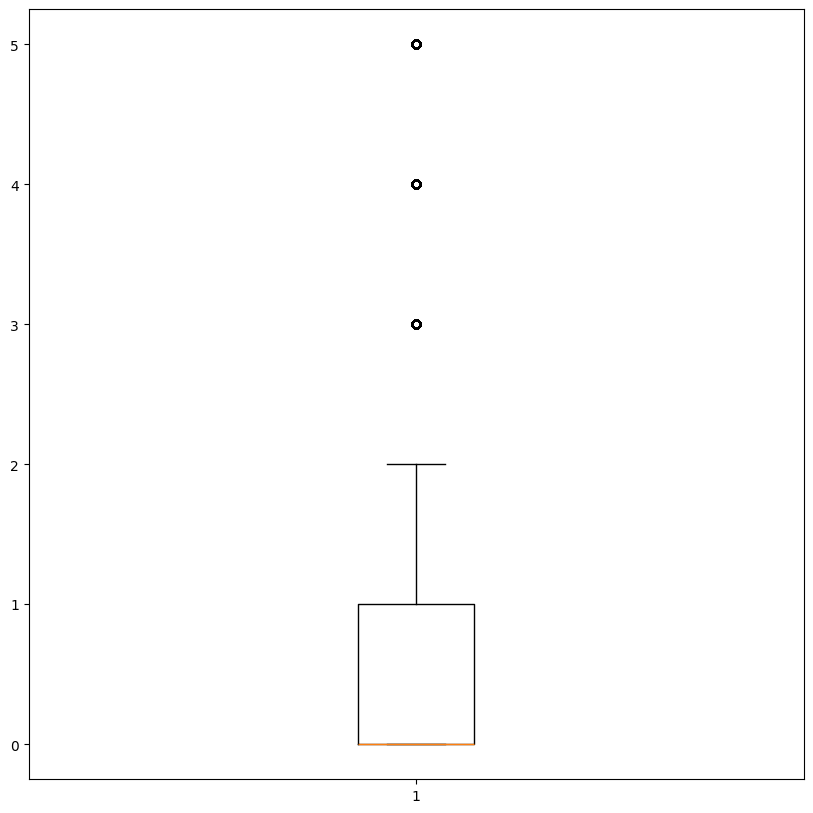

In [24]:
outliers_chart = acc.select('inq_last_6mths').toPandas()
plt.figure(figsize=(10, 10))
plt.boxplot(outliers_chart)
plt.show()

Ta sử dụng IQR để xác định ngoại lai. Giá trị ngoài khoảng này được xem là giá trị ngoại lai

In [25]:
q1, q3 = acc.approxQuantile('inq_last_6mths', [0.25, 0.75], 0.01)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
print(f"Q1: {q1}")
print(f"Q3: {q3}")
print(f"IQR: {iqr}")
print(f"Upper Bound: {upper}")
print(f"Lower Bound: {lower}")

Q1: 0.0
Q3: 1.0
IQR: 1.0
Upper Bound: 2.5
Lower Bound: -1.5


In [26]:
normal_range = acc.filter((col('inq_last_6mths') >= lower) & (col('inq_last_6mths') <= upper))
outliers = acc.filter((col('inq_last_6mths') < lower) | (col('inq_last_6mths') > upper))
print((normal_range.count()/acc.count())*100)
print((outliers.count()/acc.count())*100)

97.90736061297685
2.0926393870231497


Ta đã tìm được các giá trị ngoại lai nhưng chúng lại chiếm tỷ lệ khá lớn nên thay vì loại bỏ chúng ta sẽ thực hiện thay thế chúng bằng phương pháp thay thế ngoại lai bằng ngưỡng (Winsorizing). Cụ thể ta sẽ thay các giá trị ngoại lai < lower bằng giá trị ở phân vị thứ 5 (Ngưỡng 5% đại diện cho giá trị rất thấp của tập dữ liệu) và giá trị ngoại lai > upper ta sẽ thay bằng 0 (Tất cả các quan sát > 0 đều mang giá trị 365243)

In [27]:
new_lower, new_upper = acc.approxQuantile('inq_last_6mths', [0.05, 0.95], 0.01)
acc = acc.withColumn('inq_last_6mths', when(col('inq_last_6mths') < new_lower, new_lower).otherwise(col('inq_last_6mths')))
acc = acc.withColumn('inq_last_6mths', when(col('inq_last_6mths') > new_upper, new_upper).otherwise(col('inq_last_6mths')))

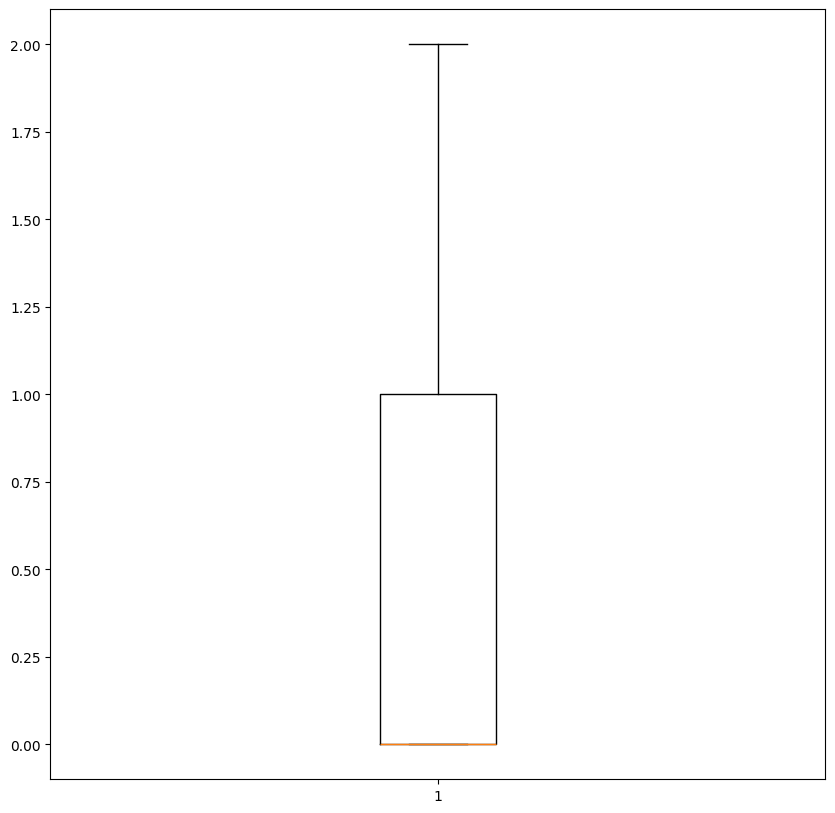

In [28]:
outliers_chart2 = acc.select('inq_last_6mths').toPandas()
plt.figure(figsize=(10, 10))
plt.boxplot(outliers_chart2)
plt.show()

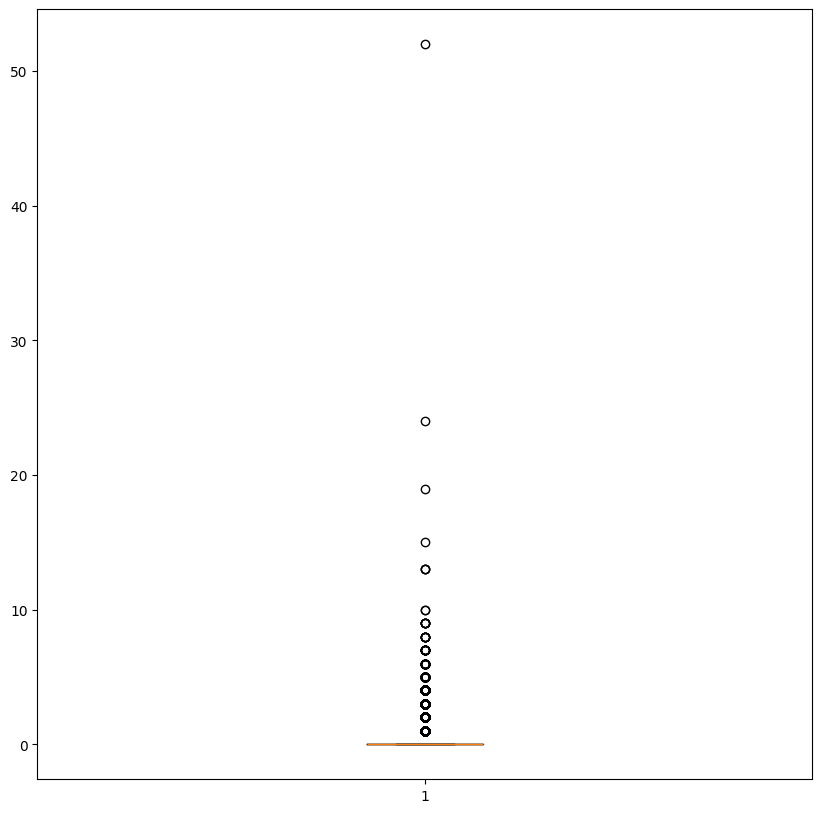

In [29]:
outliers_chart3 = acc.select('pub_rec').toPandas()
plt.figure(figsize=(10, 10))
plt.boxplot(outliers_chart3)
plt.show()

In [30]:
q1_2, q3_2 = acc.approxQuantile('pub_rec', [0.25, 0.75], 0.01)
iqr_2 = q3_2 - q1_2
upper_2 = q3_2 + 1.5 * iqr_2
lower_2 = q1_2 - 1.5 * iqr_2
print(f"Q1: {q1_2}")
print(f"Q3: {q3_2}")
print(f"IQR: {iqr_2}")
print(f"Upper Bound: {upper_2}")
print(f"Lower Bound: {lower_2}")

Q1: 0.0
Q3: 0.0
IQR: 0.0
Upper Bound: 0.0
Lower Bound: 0.0


In [31]:
normal_range_2 = acc.filter((col('pub_rec') >= lower_2) & (col('pub_rec') <= upper_2))
outliers_2 = acc.filter((col('pub_rec') < lower_2) | (col('pub_rec') > upper_2))
print((normal_range_2.count()/acc.count())*100)
print((outliers_2.count()/acc.count())*100)

87.28949298989241
12.710507010107596


In [32]:
new_lower_2, new_upper_2 = acc.approxQuantile('pub_rec', [0.05, 0.95], 0.01)
acc = acc.withColumn('pub_rec', when(col('pub_rec') < new_lower_2, new_lower_2).otherwise(col('pub_rec')))
acc = acc.withColumn('pub_rec', when(col('pub_rec') > new_upper_2, new_upper_2).otherwise(col('pub_rec')))

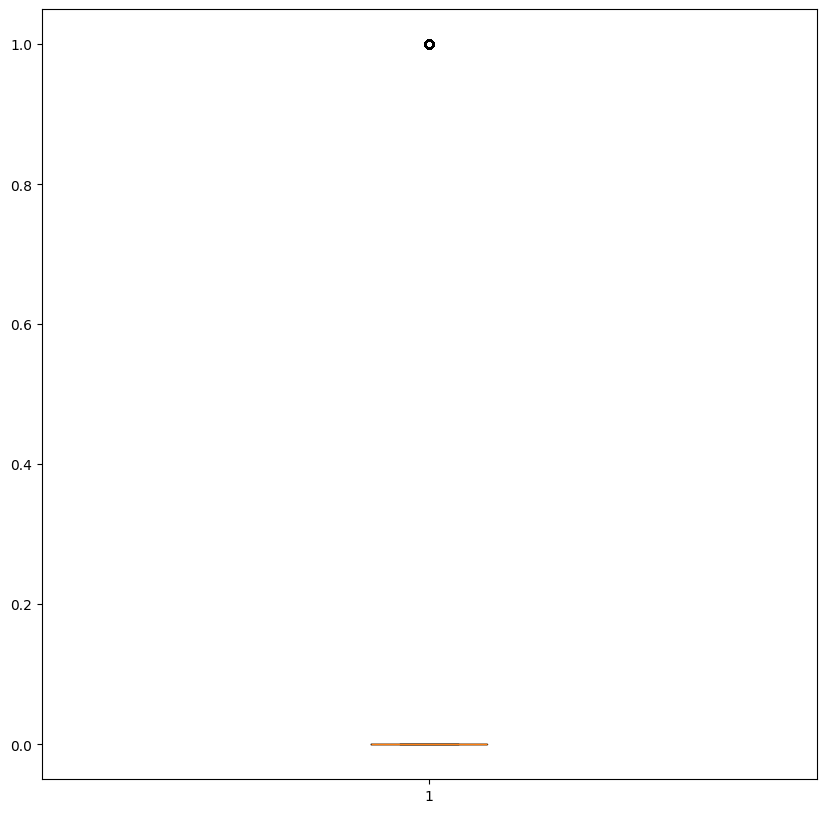

In [33]:
outliers_chart4 = acc.select('pub_rec').toPandas()
plt.figure(figsize=(10, 10))
plt.boxplot(outliers_chart4)
plt.show()



---


**Kiểm tra và xử lý các giá trị khuyết thiếu**

In [ ]:
miss_vals(acc).show(25, truncate=False)

+---------------------+-----+----------+
|column_name          |count|percentage|
+---------------------+-----+----------+
|il_util              |80050|16.31     |
|mths_since_recent_inq|60876|12.41     |
|next_pymnt_d         |56311|11.48     |
|emp_title            |54058|11.02     |
|emp_length           |41521|8.46      |
|mo_sin_old_il_acct   |18231|3.72      |
|last_pymnt_d         |640  |0.13      |
|avg_cur_bal          |40   |0.01      |
|id                   |0    |0.0       |
|loan_amnt            |0    |0.0       |
|funded_amnt          |0    |0.0       |
|funded_amnt_inv      |0    |0.0       |
|term                 |0    |0.0       |
|int_rate             |0    |0.0       |
|installment          |0    |0.0       |
|grade                |0    |0.0       |
|sub_grade            |0    |0.0       |
|home_ownership       |0    |0.0       |
|verification_status  |0    |0.0       |
|loan_status          |0    |0.0       |
|purpose              |0    |0.0       |
|earliest_cr_lin

In [ ]:
acc.describe().show()

+-------+--------------------+------------------+------------------+------------------+----------+------------------+------------------+------+---------+------------------+----------+--------------+-------------------+--------------------+-------+----------------+------------------+-----------------+------------------+-------------------+------------------+-----------------+-----------------+----------+------------+------------------+------------+------------------+--------------------+-------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+---------------------+------------------+------------------+------------------+-------------+--------------------+
|summary|                  id|         loan_amnt|       funded_amnt|   funded_amnt_inv|      term|          int_rate|       installment| grade|sub_grade|         emp_title|emp_length|home_ownership|verification_status|         loan_status|purpo

Ta sẽ xử lý giá trị khuyết thiếu bằng cách điền trung bình đối với những giá trị kiểu số học và điền mode với những giá trị kiểu string
- Ưu điểm: Dễ thực hiện, đơn giản, giữ nguyên dạng dữ liệu
- Nhược điểm: Mất tính đa dạng của dữ liệu

In [34]:
acc = fill_missing_values(acc)

Tổng số biến đã điền giá trị khuyết thiếu là: 9




---


**Kiểm tra và xử lý giá trị trùng lặp**

In [ ]:
duplicates(acc)

Số dòng trùng lặp là: 0




---
**Chuẩn hóa dữ liệu**

Ta sẽ sử dụng Min - Max Scaling để chuẩn hóa


In [35]:
cols_to_scaled = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'funded_amnt_inv', 'int_rate', 'installment', 'fico_range_low',
                  'fico_range_high', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low'
                  , 'il_util', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi', 'avg_cur_bal', 'mo_sin_old_il_acct', 'mths_since_recent_inq'
                  , 'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bc_limit', 'inq_last_6mths']
acc = min_max_scaler(acc, cols_to_scaled)

In [ ]:
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 67)


Ta xóa các cột gốc chưa được chuẩn hóa để tránh gây đa cộng tuyến


In [36]:
acc = acc.drop('loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'funded_amnt_inv', 'int_rate', 'installment', 'fico_range_low',
                  'fico_range_high', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low'
                  , 'il_util', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi', 'avg_cur_bal', 'mo_sin_old_il_acct', 'mths_since_recent_inq'
                  , 'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bc_limit', 'inq_last_6mths')
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 42)


In [ ]:
acc.describe().show()

+-------+--------------------+----------+------+----------+--------------+-------------------+--------------------+-------+-------------------+----------+------------+------------+------------------+-------------+--------------------+------------------+------------------+----------------------+-------------------+-------------------+---------------------+----------------------+-------------------+----------------------+----------------------+----------------------+---------------------------+--------------------------+-------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+-------------------------+----------------------------+-------------------------+----------------------+---------------------+---------------------+
|summary|                  id|      term| grade|emp_length|home_ownership|verification_status|         loan_status|purpose|            pub_rec|recoveries|last_pymnt_d|next_pymnt_d|last_credit_pull_d|



---


**Mã hóa các biến phân loại**


In [ ]:
categorical_counts(acc)

Cột 'id' có 490720 giá trị khác nhau.
Cột 'term' có 2 giá trị khác nhau.
Cột 'grade' có 7 giá trị khác nhau.
Cột 'sub_grade' có 35 giá trị khác nhau.
Cột 'emp_title' có 128517 giá trị khác nhau.
Cột 'emp_length' có 11 giá trị khác nhau.
Cột 'home_ownership' có 4 giá trị khác nhau.
Cột 'verification_status' có 3 giá trị khác nhau.
Cột 'purpose' có 13 giá trị khác nhau.
Cột 'earliest_cr_line' có 684 giá trị khác nhau.
Cột 'last_pymnt_d' có 15 giá trị khác nhau.
Cột 'next_pymnt_d' có 3 giá trị khác nhau.
Cột 'last_credit_pull_d' có 18 giá trị khác nhau.
Cột 'hardship_flag' có 2 giá trị khác nhau.
Cột 'debt_settlement_flag' có 2 giá trị khác nhau.
Tổng số biến phân loại là: 15


Ta sẽ loại bỏ một số biến phân loại không cần thiết

In [37]:
acc = acc.drop('emp_title', 'sub_grade')

In [38]:
acc = acc.drop('earliest_cr_line')

In [ ]:
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 39)


In [ ]:
print(target_corrs(acc))

Column: scaled_last_fico_range_low, Correlation with loan_status: -0.4674830772534086
Column: scaled_last_fico_range_high, Correlation with loan_status: -0.4218234471846446
Column: id, Correlation with loan_status: -0.11680605405693167
Column: scaled_total_rec_prncp, Correlation with loan_status: -0.07374370972932114
Column: scaled_total_pymnt, Correlation with loan_status: -0.05973867555773348
Column: scaled_total_pymnt_inv, Correlation with loan_status: -0.05972875251065595
Column: scaled_mths_since_recent_inq, Correlation with loan_status: -0.04447809213399885
Column: scaled_last_pymnt_amnt, Correlation with loan_status: -0.043090286196750545
Column: scaled_fico_range_low, Correlation with loan_status: -0.04050279397860556
Column: scaled_fico_range_high, Correlation with loan_status: -0.040502105623478654
Column: scaled_total_bc_limit, Correlation with loan_status: -0.033347582537433994
Column: scaled_tot_hi_cred_lim, Correlation with loan_status: -0.031072048747309008
Column: scale

In [39]:
col_onehot_encoding = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose',
                       'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_flag', 'debt_settlement_flag']

acc = label_encoding(acc, col_onehot_encoding)
acc = onehot_encoding(acc, col_onehot_encoding)

Có 11 biến đã được one-hot encoding


Tiếp tục ta xóa các cột chưa được mã hóa để tránh gây đa cộng tuyến

In [40]:
acc = acc.drop('term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose',
                       'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_flag', 'debt_settlement_flag')
print(f"({acc.count()}, {len(acc.columns)})")

(490720, 39)


In [ ]:
acc.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_status: integer (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- scaled_loan_amnt: double (nullable = true)
 |-- scaled_funded_amnt: double (nullable = true)
 |-- scaled_funded_amnt_inv: double (nullable = true)
 |-- scaled_int_rate: double (nullable = true)
 |-- scaled_installment: double (nullable = true)
 |-- scaled_fico_range_low: double (nullable = true)
 |-- scaled_fico_range_high: double (nullable = true)
 |-- scaled_total_pymnt: double (nullable = true)
 |-- scaled_total_pymnt_inv: double (nullable = true)
 |-- scaled_total_rec_prncp: double (nullable = true)
 |-- scaled_last_pymnt_amnt: double (nullable = true)
 |-- scaled_last_fico_range_high: double (nullable = true)
 |-- scaled_last_fico_range_low: double (nullable = true)
 |-- scaled_il_util: double (nullable = true)
 |-- scaled_open_rv_24m: double (nullable = true)
 |-- scaled_max_bal_bc: double (nullable = true)
 |-- s

# Xây dựng mô hình

In [41]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

# Gồm 20 biến được chọn
feature_cols = [
    'emp_length_Vec',
    'home_ownership_Vec',
    'purpose_Vec',
    'verification_status_Vec',
    'scaled_inq_fi',
    'scaled_total_rev_hi_lim',
    'scaled_funded_amnt_inv',
    'scaled_max_bal_bc',
    'scaled_il_util',
    'scaled_mo_sin_old_il_acct',
    'scaled_inq_last_6mths',
    'scaled_mths_since_recent_inq',
    'scaled_funded_amnt',
    'scaled_fico_range_low',
    'scaled_fico_range_high',
    'scaled_num_tl_op_past_12m',
    'scaled_installment',
    'scaled_total_bc_limit',
    'scaled_tot_hi_cred_lim',
    'scaled_open_rv_24m'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

acc = assembler.transform(acc)
train, test = acc.randomSplit([0.7, 0.3], seed=42)

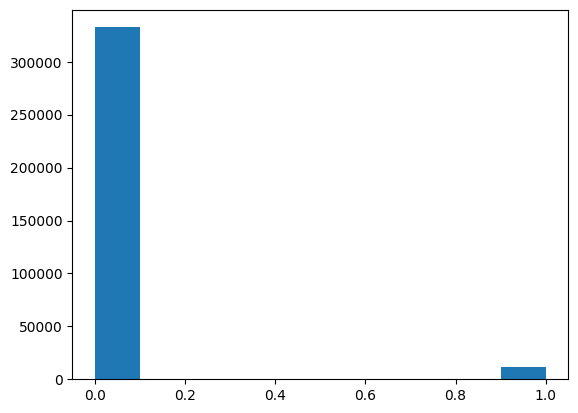

In [42]:
imbalance = train.select("loan_status").toPandas()
plt.hist(imbalance)
plt.show()

**Mất cân bằng dữ liệu**
- Class imbalance problem - Dữ liệu trong bài toán phân loại có sự chênh lệch lớn về số lượng mẫu thuộc các lớp khác nhau. Ở đây cho thấy rắng có nhiều khoản vay được trả hơn khoản vay không được trả. Vấn đề này có thể ảnh hưởng tới chất lượng của mô hình, khiến nó có thể "thiên vị" với lớp khoản vay được trả.
- Ta sẽ thực hiện Random Oversampling: Phương pháp này đơn giản là sao chép các mẫu từ lớp thiểu số (minority class) một cách ngẫu nhiên cho đến khi số lượng mẫu của lớp thiểu số cân bằng với lớp đa số (majority class). Ưu điểm là dễ thực hiện nhưng có thể dẫn tới overfitting


In [43]:
class_count = imbalance['loan_status'].value_counts()
major = class_count[0]
minor = class_count[1]

In [44]:
major_class = train.filter(col('loan_status') == 0)
minor_class = train.filter(col('loan_status') == 1)
oversampled_minor_class = minor_class.sample(withReplacement=True, fraction=major/minor)
balanced = major_class.unionAll(oversampled_minor_class)
balanced.groupBy('loan_status').count().show()

+-----------+------+
|loan_status| count|
+-----------+------+
|          0|332554|
|          1|332233|
+-----------+------+



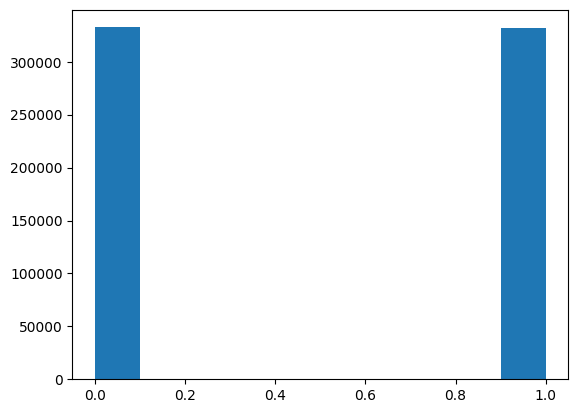

In [45]:
state = balanced.select("loan_status").toPandas()
plt.hist(state)
plt.show()

In [46]:
lr = LogisticRegression(featuresCol='features', labelCol='loan_status')
lr_model = lr.fit(balanced)

predictions = lr_model.transform(test)

# Đánh giá mô hình

**Lựa chọn chỉ số đánh giá mô hình:**
- AUC: Ít bị ảnh hưởng bởi tỷ lệ mất cân bằng dữ liệu
- F1-Score: Ở đây ta muốn tối đa hóa số lượng true positive trong khi vẫn giảm thiểu các lỗi (false positive và false negative)
- Recall: Giúp bạn tăng true positive và giảm false negative, đảm bảo rằng mô hình phát hiện được các trường hợp dương tính thực sự.

**Mô hình ở ngưỡng mặc định 0.5:**

In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import classification_report

evaluator = BinaryClassificationEvaluator(labelCol='loan_status')
auc = evaluator.evaluate(predictions)

evaluator_multi = MulticlassClassificationEvaluator(labelCol="loan_status", predictionCol="prediction")
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})
f1 = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Area under the ROC Curve: {auc}")

# Chuyển đổi từ PySpark DataFrame sang Pandas
pandas_df = predictions.select("loan_status", "prediction").toPandas()

# Tính toán classification_report từ sklearn
report = classification_report(pandas_df['loan_status'], pandas_df['prediction'])
print(report)

Precision: 0.9497418014444067
Recall: 0.6346532025939208
F1: 0.7483971028253433
Area under the ROC Curve: 0.6844823724119129
              precision    recall  f1-score   support

           0       0.98      0.63      0.77    142071
           1       0.06      0.63      0.10      4888

    accuracy                           0.63    146959
   macro avg       0.52      0.63      0.44    146959
weighted avg       0.95      0.63      0.75    146959



# Ma trận nhầm lẫn

In [48]:
TP = predictions.filter((predictions.loan_status == 1) & (predictions.prediction == 1)).count() # Thực tế không trả được nợ và dự đoán không trả được nợ
TN = predictions.filter((predictions.loan_status == 0) & (predictions.prediction == 0)).count() # Thực tế trả được nợ và dự đoán trả được nợ
FP = predictions.filter((predictions.loan_status == 0) & (predictions.prediction == 1)).count() # Thực tế trả được nợ nhưng dự đoán không trả được nợ
FN = predictions.filter((predictions.loan_status == 1) & (predictions.prediction == 0)).count() # Thực tế không trả được nợ nhưng dự đoán trả được nợ

print(f"TP: {TP}")
print(f"TN: {TN}")
print(f"FP: {FP}")
print(f"FN: {FN}")

TP: 3093
TN: 90175
FP: 51896
FN: 1795


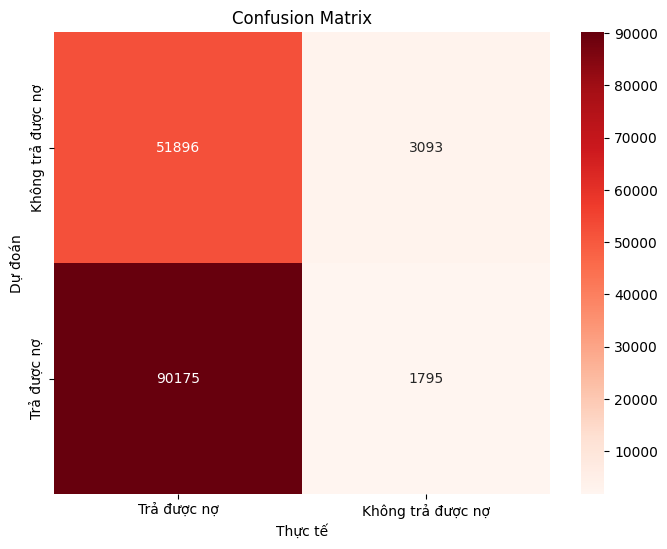

In [49]:
import seaborn as sns

cm = np.array([[FP, TP], [TN, FN]])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Trả được nợ', 'Không trả được nợ'], yticklabels=['Không trả được nợ', 'Trả được nợ'])
plt.xlabel('Thực tế')
plt.ylabel('Dự đoán')
plt.title('Confusion Matrix')
plt.show()

**Mô hình khi siết ngưỡng ở mức 0.45:**

In [59]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Bước 1: UDF để áp dụng ngưỡng 0.45
def apply_threshold2(probability, threshold=0.45):
    return int(probability[1] >= threshold)  # lấy xác suất lớp 1

threshold_udf2 = udf(lambda prob: apply_threshold2(prob, 0.45), IntegerType())

# Bước 2: Tạo cột mới với nhãn phân loại tùy chỉnh
predictions_with_threshold2 = predictions.withColumn("custom_prediction2", threshold_udf2(predictions["probability"]))


In [60]:
# Chuyển sang pandas để dùng sklearn
pandas_df_custom2 = predictions_with_threshold2.select("loan_status", "custom_prediction2").toPandas()

print(classification_report(pandas_df_custom2['loan_status'], pandas_df_custom2['custom_prediction2']))

              precision    recall  f1-score   support

           0       0.98      0.51      0.67    142071
           1       0.05      0.75      0.09      4888

    accuracy                           0.52    146959
   macro avg       0.52      0.63      0.38    146959
weighted avg       0.95      0.52      0.65    146959



In [61]:
TP3 = predictions_with_threshold2.filter((predictions_with_threshold2.loan_status == 1) & (predictions_with_threshold2.custom_prediction2 == 1)).count() # Thực tế không trả được nợ và dự đoán không trả được nợ
TN3 = predictions_with_threshold2.filter((predictions_with_threshold2.loan_status == 0) & (predictions_with_threshold2.custom_prediction2 == 0)).count() # Thực tế trả được nợ và dự đoán trả được nợ
FP3 = predictions_with_threshold2.filter((predictions_with_threshold2.loan_status == 0) & (predictions_with_threshold2.custom_prediction2 == 1)).count() # Thực tế trả được nợ nhưng dự đoán không trả được nợ
FN3 = predictions_with_threshold2.filter((predictions_with_threshold2.loan_status == 1) & (predictions_with_threshold2.custom_prediction2 == 0)).count() # Thực tế không trả được nợ nhưng dự đoán trả được nợ

print(f"TP: {TP3}")
print(f"TN: {TN3}")
print(f"FP: {FP3}")
print(f"FN: {FN3}")

TP: 3648
TN: 72889
FP: 69182
FN: 1240


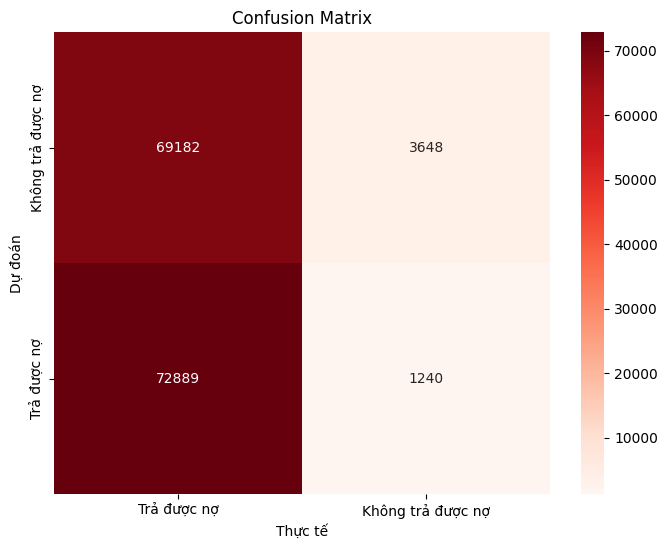

In [62]:
import seaborn as sns

cm3 = np.array([[FP3, TP3], [TN3, FN3]])
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Reds', xticklabels=['Trả được nợ', 'Không trả được nợ'], yticklabels=['Không trả được nợ', 'Trả được nợ'])
plt.xlabel('Thực tế')
plt.ylabel('Dự đoán')
plt.title('Confusion Matrix')
plt.show()

In [63]:
evaluator1 = BinaryClassificationEvaluator(labelCol='loan_status')
auc = evaluator1.evaluate(predictions_with_threshold2)

print(f"Area under the ROC Curve: {auc}")

Area under the ROC Curve: 0.6844848160968269
